# Model notebook for Endless Line Eleven Strategy data challenge

## Useful imports

In [ ]:
!pip install feature-engine --quiet

In [ ]:
!pip install holidays --quiet

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
WAITING_PATH = 'data/waiting_times.csv'
LINK_PATH = 'data/link_attraction_park.csv'
ATTENDANCE_PATH = 'data/attendance.csv'
ENTITY_PATH = 'data/entity_schedule.csv'
WEATHER_PATH = 'data/weather_data.csv'
PARADE_PATH = 'data/parade_night_show.xlsx'

In [3]:
def join_and_clean(waiting_times_file, link_attraction_park_file, entity_schedule_file, attendance_file,
                    weather_file, parade_file):
    # Read waiting times dataframe
    df = pd.read_csv(waiting_times_file)

    # Read link attraction park dataframe
    park = pd.read_csv(link_attraction_park_file, sep=';')

    # Merge waiting times and park dataframes
    df = pd.merge(df, park, left_on='ENTITY_DESCRIPTION_SHORT', right_on='ATTRACTION')

    # Filter by park
    df = df[df.PARK == 'PortAventura World']

    # Drop unnecessary columns
    df.drop(columns=['ENTITY_DESCRIPTION_SHORT', 'PARK'], inplace=True)

    # Convert columns to datetime
    df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])
    df['FIN_TIME'] = pd.to_datetime(df['FIN_TIME'])
    df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])

    # Read entity schedule dataframe
    schedule = pd.read_csv(entity_schedule_file)

    # Convert columns to datetime
    schedule['DEB_TIME'] = pd.to_datetime(schedule['DEB_TIME'])
    schedule['FIN_TIME'] = pd.to_datetime(schedule['FIN_TIME'])
    schedule['WORK_DATE'] = pd.to_datetime(schedule['WORK_DATE'])

    # Get attractions open hours info
    schedule_attr = schedule[schedule.ENTITY_TYPE == 'ATTR']
    schedule_attr = schedule_attr.rename(columns={
        'DEB_TIME': 'DEB_TIME_ATTR',
        'FIN_TIME': 'FIN_TIME_ATTR',
        'REF_CLOSING_DESCRIPTION': 'REF_CLOSING_DESCRIPTION_ATTR'
    })

    # Merge attractions schedule with waiting times dataframe
    df = pd.merge(df, schedule_attr, how='left',
                  left_on=['WORK_DATE', 'ATTRACTION'],
                  right_on=['WORK_DATE', 'ENTITY_DESCRIPTION_SHORT'])

    # Drop unnecessary columns
    df = df.drop(columns=['ENTITY_DESCRIPTION_SHORT', 'ENTITY_TYPE', 'UPDATE_TIME'])

    # Get park open hours information
    schedule_park = schedule[schedule.ENTITY_TYPE == 'PARK']
    schedule_park = schedule_park[schedule_park['ENTITY_DESCRIPTION_SHORT'] == 'PortAventura World']
    schedule_park = schedule_park.rename(columns={
        'DEB_TIME': 'DEB_TIME_PARK',
        'FIN_TIME': 'FIN_TIME_PARK',
        'REF_CLOSING_DESCRIPTION': 'REF_CLOSING_DESCRIPTION_PARK'
    })

    # Group by work date and aggregate park schedule information
    schedule_park = schedule_park.groupby('WORK_DATE').agg({
        'DEB_TIME_PARK': 'min',
        'FIN_TIME_PARK': 'max',
        'REF_CLOSING_DESCRIPTION_PARK': 'first'
    }).reset_index()

    # Merge park schedule with waiting times dataframe
    df = pd.merge(df, schedule_park, how='left', on='WORK_DATE')

    # Read park attendance dataframe
    park_attendance = pd.read_csv(attendance_file)
    park_attendance = park_attendance[park_attendance.FACILITY_NAME == 'PortAventura World']
    park_attendance['USAGE_DATE'] = pd.to_datetime(park_attendance['USAGE_DATE'])
    park_attendance.drop(columns=['FACILITY_NAME'], inplace=True)

    # Merge attendance with waiting times dataframe
    df = pd.merge(df, park_attendance, how='left', left_on='WORK_DATE', right_on='USAGE_DATE')
    df.drop(columns=['USAGE_DATE'], inplace=True)
    df = df.rename(columns={'attendance': 'ATTENDANCE_PARK'})

    # Read weather data
    weather = pd.read_csv(weather_file)
    weather_sample = weather[['dt_iso', 'temp', 'wind_speed', 'weather_main']].copy()
    weather_sample['dt'] = weather_sample['dt_iso'].str[:19]
    #weather_sample.loc[:, 'dt'] = weather_sample[:, 'dt_iso'].str[:19].copy()
    weather_sample['dt'] = pd.to_datetime(weather_sample['dt'])
    weather_sample.drop(columns=['dt_iso'], inplace=True)

    # Create dataset with full datetime
    temp = pd.DataFrame()
    temp['DEB_TIME'] = df['DEB_TIME'].unique()

    # Add weather info
    datetime_weather = pd.merge(temp, weather_sample, how='left', left_on='DEB_TIME', right_on='dt')
    datetime_weather = datetime_weather.sort_values(by='DEB_TIME')

    # Fill NaNs with closest values
    datetime_weather['wind_speed'] = datetime_weather['wind_speed'].fillna(method='ffill')
    datetime_weather['weather_main'] = datetime_weather['weather_main'].fillna(method='ffill')
    datetime_weather['temp'] = datetime_weather['temp'].fillna(method='ffill')
    datetime_weather.drop(columns='dt', inplace=True)

    # Merge weather data with main dataframe
    df = pd.merge(df, datetime_weather, how='left', on='DEB_TIME')

    # Read parade data
    parade = pd.read_excel(parade_file, index_col=0)
    parade['PARADE_2'].fillna('12:10:00', inplace=True)

    # Format datetime
    parade['PARADE_1'] = parade['WORK_DATE'].astype(str) + ' ' + parade['PARADE_1'].astype(str)
    parade['PARADE_1'] = pd.to_datetime(parade['PARADE_1'])
    parade['PARADE_2'] = parade['WORK_DATE'].astype(str) + ' ' + parade['PARADE_2'].astype(str)
    parade['PARADE_2'] = pd.to_datetime(parade['PARADE_2'])
    parade['NIGHT_SHOW'] = parade['WORK_DATE'].astype(str) + ' ' + parade['NIGHT_SHOW'].astype(str)
    parade['NIGHT_SHOW'] = pd.to_datetime(parade['NIGHT_SHOW'])

    # Merge parade data with main dataframe
    df = pd.merge(df, parade, how='left', on='WORK_DATE')

    return df

In [4]:
df_merged = join_and_clean(WAITING_PATH, LINK_PATH, ENTITY_PATH, ATTENDANCE_PATH, WEATHER_PATH, PARADE_PATH)

/var/folders/0d/g2v1y9v51rb1_3s53whbwxym0000gn/T/ipykernel_24278/606471629.py:94: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datetime_weather['wind_speed'] = datetime_weather['wind_speed'].fillna(method='ffill')
/var/folders/0d/g2v1y9v51rb1_3s53whbwxym0000gn/T/ipykernel_24278/606471629.py:95: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datetime_weather['weather_main'] = datetime_weather['weather_main'].fillna(method='ffill')
/var/folders/0d/g2v1y9v51rb1_3s53whbwxym0000gn/T/ipykernel_24278/606471629.py:96: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datetime_weather['temp'] = datetime_weather['temp'].fillna(method='ffill')


In [5]:
df_merged.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,...,DEB_TIME_PARK,FIN_TIME_PARK,REF_CLOSING_DESCRIPTION_PARK,ATTENDANCE_PARK,temp,wind_speed,weather_main,NIGHT_SHOW,PARADE_1,PARADE_2
0,2018-01-01,2018-01-01 21:00:00,21,2018-01-01 21:15:00,0,2.0,0.0,0.0,0.0,0,...,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.80,7.58,Clouds,NaT,NaT,NaT
1,2018-01-01,2018-01-01 15:00:00,15,2018-01-01 15:15:00,20,2.0,51.0,75.0,75.0,15,...,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,8.07,8.63,Rain,NaT,NaT,NaT
2,2018-01-01,2018-01-01 20:15:00,20,2018-01-01 20:30:00,0,2.0,0.0,0.0,0.0,0,...,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.44,7.96,Clouds,NaT,NaT,NaT
3,2018-01-01,2018-01-01 11:45:00,11,2018-01-01 12:00:00,50,2.0,54.0,75.0,75.0,15,...,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,6.35,9.69,Rain,NaT,NaT,NaT
4,2018-01-01,2018-01-01 17:00:00,17,2018-01-01 17:15:00,20,2.0,29.0,75.0,75.0,15,...,2018-01-01 08:30:00,2018-01-01 22:00:00,None,NaN,7.76,9.77,Rain,NaT,NaT,NaT


In [6]:
df_merged.isna().sum()

WORK_DATE                             0
DEB_TIME                              0
DEB_TIME_HOUR                         0
FIN_TIME                              0
WAIT_TIME_MAX                         0
NB_UNITS                              0
GUEST_CARRIED                         0
CAPACITY                              0
ADJUST_CAPACITY                       0
OPEN_TIME                             0
UP_TIME                               0
DOWNTIME                              0
NB_MAX_UNIT                           0
ATTRACTION                            0
REF_CLOSING_DESCRIPTION_ATTR    2215559
DEB_TIME_ATTR                   1068927
FIN_TIME_ATTR                   1068927
DEB_TIME_PARK                   1067639
FIN_TIME_PARK                   1067639
REF_CLOSING_DESCRIPTION_PARK    2369821
ATTENDANCE_PARK                  713543
temp                                  0
wind_speed                            0
weather_main                          0
NIGHT_SHOW                      1427093


## Preprocessing and feature engineering

- Attendance
- Timeslot features
- Individual attraction features
- Relationship with other attractions 
- Interactions with other park events
- Weather

In [7]:
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1200x600 with 0 Axes>

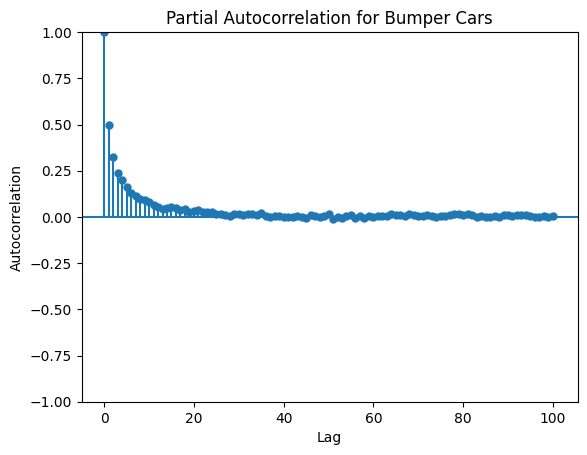

In [9]:
# Set the 'date' column as the index if it's not already
acf_data = df_merged[df_merged['ATTRACTION']=='Bumper Cars']
acf_data.set_index('DEB_TIME', inplace=True)

# Plot the autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(acf_data['WAIT_TIME_MAX'], lags=100, title='Partial Autocorrelation for Bumper Cars')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

<Figure size 1200x600 with 0 Axes>

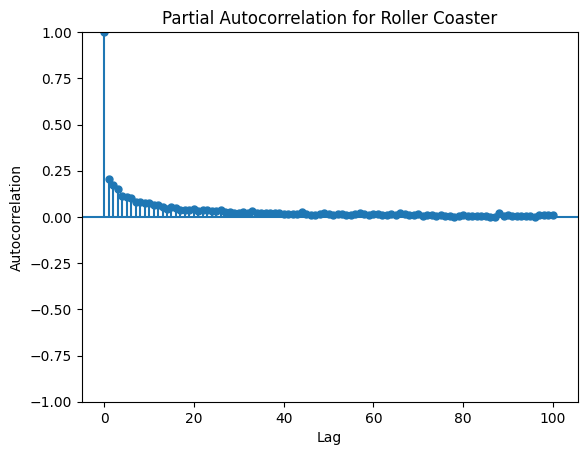

In [10]:
# Set the 'date' column as the index if it's not already
acf_data = df_merged[df_merged['ATTRACTION']=='Roller Coaster']
acf_data.set_index('DEB_TIME', inplace=True)

# Plot the autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(acf_data['WAIT_TIME_MAX'], lags=100, title='Partial Autocorrelation for Roller Coaster')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show();

In [11]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


In [12]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

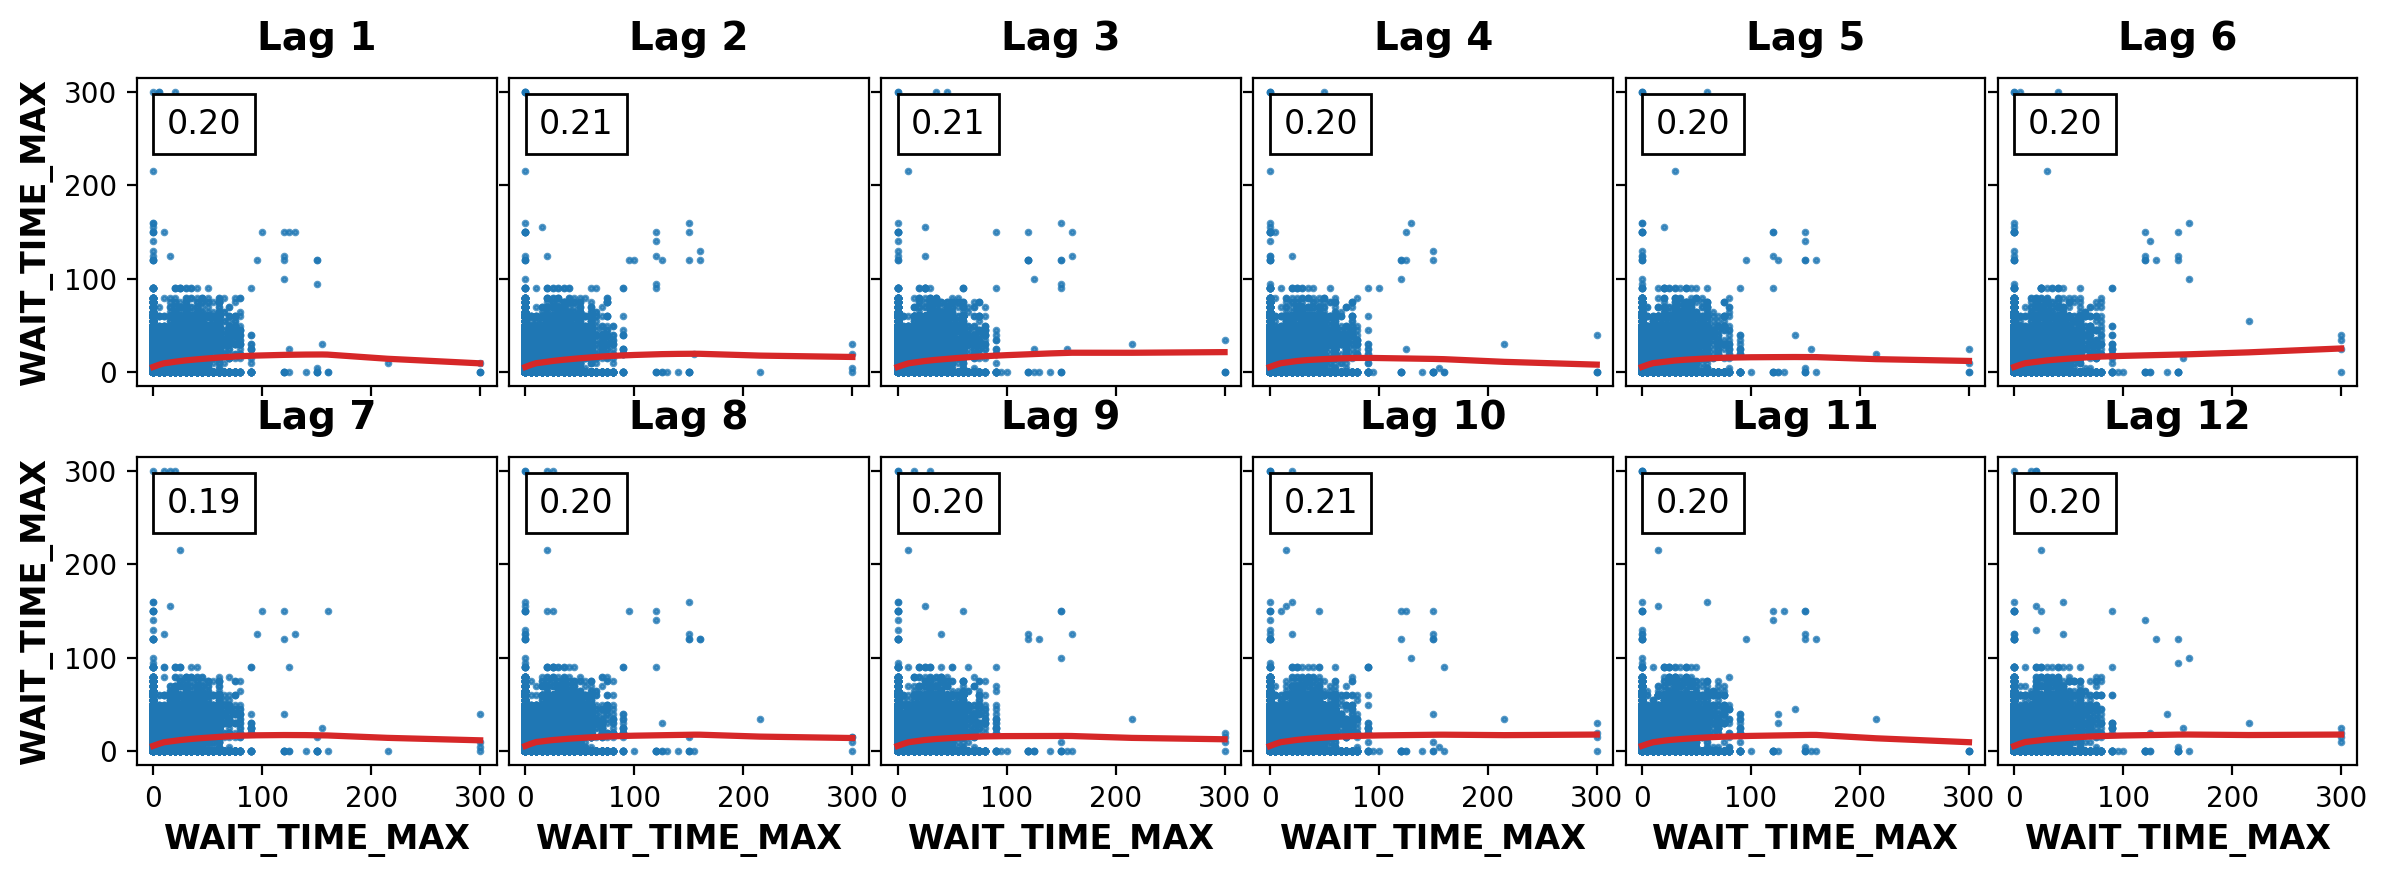

In [13]:
_ = plot_lags(df_merged[df_merged['ATTRACTION']=='Roller Coaster']['WAIT_TIME_MAX'], lags=12, nrows=2)

In [14]:
df_attendance = pd.read_csv(ATTENDANCE_PATH)
df_attendance = df_attendance[df_attendance['FACILITY_NAME']=='PortAventura World']
df_attendance['USAGE_DATE'] = pd.to_datetime(df_attendance['USAGE_DATE'])

fig = px.line(df_attendance, x='USAGE_DATE', y='attendance', markers=True, line_shape='linear',
              labels={'attendance': 'Attendance'},
              title='Evolution of ATTENDANCE_PARK over Time',
              template='plotly_dark')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Attendance')
fig.show()

### Building a forecasting model for the daily attendance (7 day horizon)

Daily attendance is surely the most important predictor of the waiting times. Lower global attendance will result in lower waiting times. In order to have the best forecast possible for each attraction, we will first build an individual model to predict the daily attendance in the park. 

In [15]:
import holidays
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [16]:
df_attendance.head()

,USAGE_DATE,FACILITY_NAME,attendance
0,2018-06-01,PortAventura World,46804
2,2018-06-02,PortAventura World,57940
4,2018-06-03,PortAventura World,44365
6,2018-06-04,PortAventura World,37617
8,2018-06-05,PortAventura World,32438


<Figure size 1200x600 with 0 Axes>

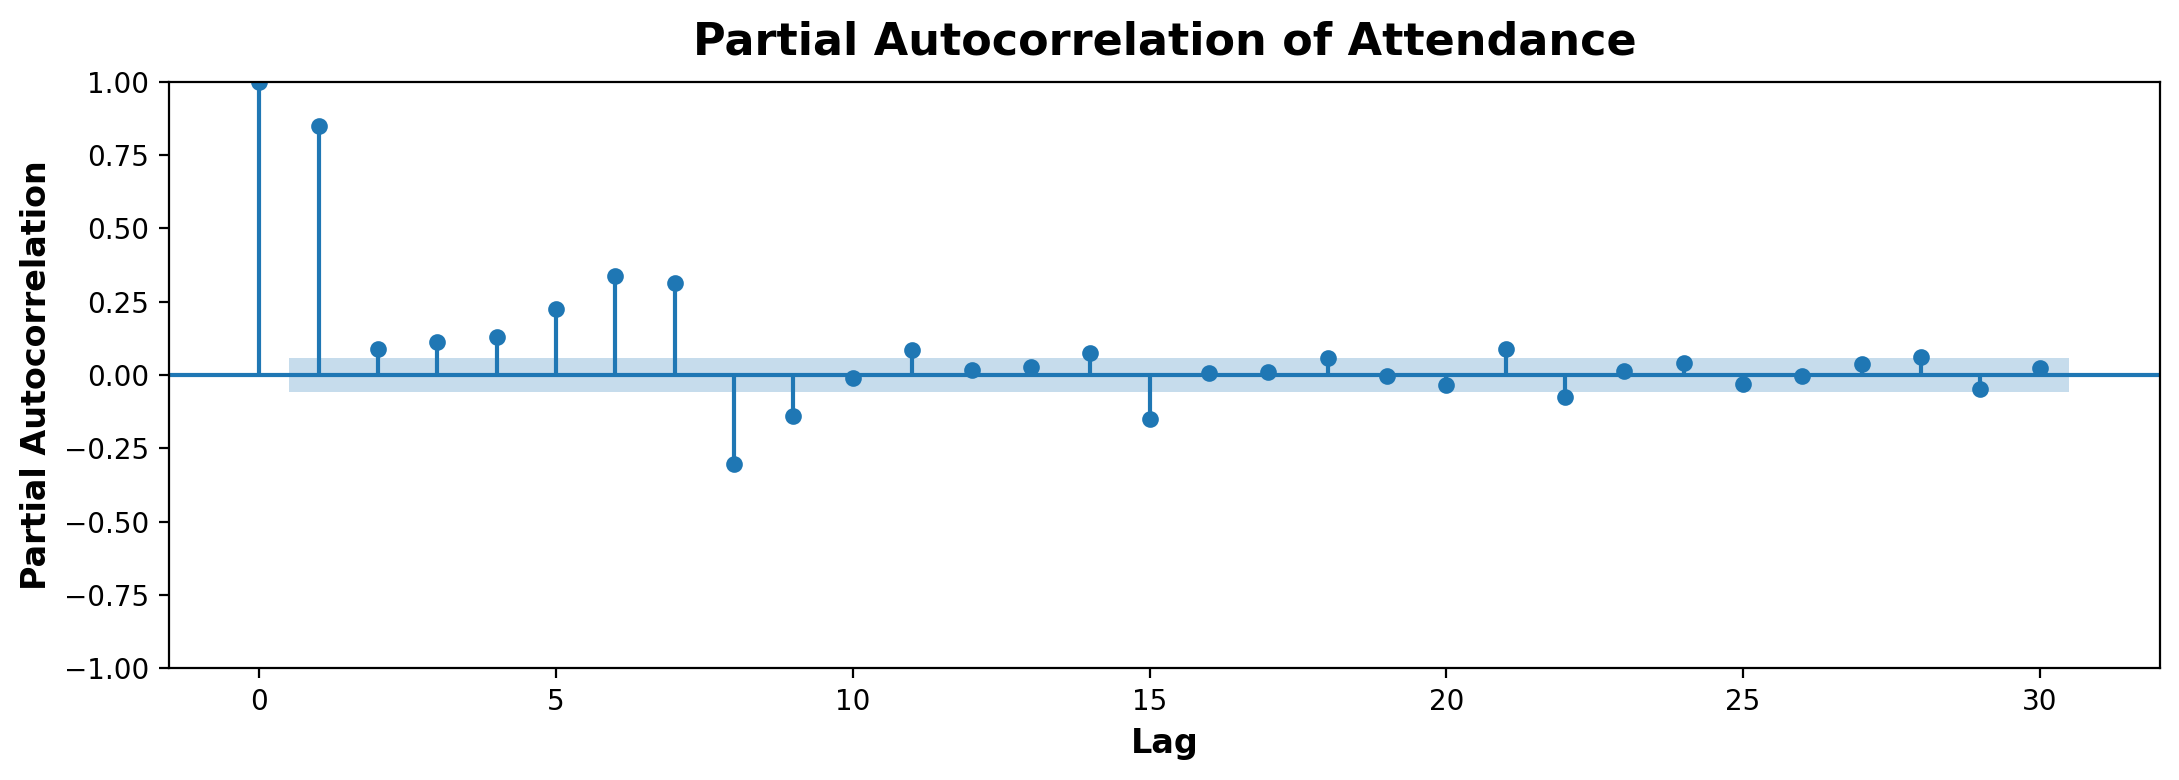

In [17]:
# Plot the PACF

plt.figure(figsize=(12, 6))
plot_pacf(df_attendance['attendance'].dropna(), lags=30, title=f'Partial Autocorrelation of Attendance')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [18]:
def clean_attendance(df):
    """
    Cleans the attendance DataFrame by removing data within the Covid-19 period.

    Parameters:
    - df (pd.DataFrame): The attendance DataFrame containing the 'USAGE_DATE' and 'FACILITY_NAME' columns.

    Returns:
    pd.DataFrame: Cleaned DataFrame with data outside the Covid-19 period, and 'FACILITY_NAME' column dropped.
    """
    # Remove Covid Period
    start = pd.to_datetime('2020-03-14')
    end = pd.to_datetime('2021-09-01')

    # Create a boolean mask for the date range
    mask = (df['USAGE_DATE'] < start) | (df['USAGE_DATE'] > end)

    # Apply the mask to filter the dataset
    filtered_df = df[mask]

    # Drop FACILITY_NAME since all the dataset is already filtered for Portaventura
    filtered_df.drop(columns=['FACILITY_NAME'], inplace=True)

    return filtered_df

def features_attendance(df):
    """
    Adds features to the attendance DataFrame, including Spanish holidays, seasons, month, year, and weekend indicators,
    as well as lag features based on partial autocorrelation.

    Parameters:
    - df (pd.DataFrame): The attendance DataFrame containing the 'USAGE_DATE' and 'attendance' columns.

    Returns:
    pd.DataFrame: DataFrame with additional features such as 'holiday', 'season', 'month', 'year', 'is_weekend',
                  and lag features.
    """
    # Spanish holiday feature using the 'holidays' library
    es_holidays = holidays.Spain()
    df['holiday'] = df['USAGE_DATE'].dt.date.astype(str).isin(es_holidays).astype(int)

    # Seasons feature
    df['season'] = (df['USAGE_DATE'].dt.month % 12 + 3) // 3 

    # Month feature
    df['month'] = df['USAGE_DATE'].dt.month

    # year feature
    df['year'] = df['USAGE_DATE'].dt.year

    # Weekend feature
    df['is_weekend'] = (df['USAGE_DATE'].dt.dayofweek >= 5).astype(int)

    # Create Lag-Features
    lags = 20 
    pacf_values = pacf(df['attendance'], nlags=lags)
    significant_lags = np.where(np.abs(pacf_values) > 0.2)[0]

    # Add lag features to the DataFrame
    for lag in significant_lags:
        if lag >= 7:  # Exclude lag 0
            col_name = f'lag_{lag}'
            df[col_name] = df['attendance'].shift(lag)

    return df


In [19]:
df_attendance = clean_attendance(df_attendance)
df_attendance = features_attendance(df_attendance)

/var/folders/0d/g2v1y9v51rb1_3s53whbwxym0000gn/T/ipykernel_24278/1851943172.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
df_attendance.head()

,USAGE_DATE,attendance,holiday,season,month,year,is_weekend,lag_7,lag_8
0,2018-06-01,46804,0,3,6,2018,0,NaN,NaN
2,2018-06-02,57940,0,3,6,2018,1,NaN,NaN
4,2018-06-03,44365,0,3,6,2018,1,NaN,NaN
6,2018-06-04,37617,0,3,6,2018,0,NaN,NaN
8,2018-06-05,32438,0,3,6,2018,0,NaN,NaN


## Models to Predict Attendance

### LightGBM

In [21]:
# Features and target variable
X = df_attendance.drop(['attendance', 'USAGE_DATE'], axis=1)
y = df_attendance['attendance']

# Initialize TimeSeriesSplit with an increasing window
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Training the model
    num_round = 1000
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

    # Predictions on the test set
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    # Model evaluation
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 165, number of used features: 5
[LightGBM] [Info] Start training from score 45526.272727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### XGBoost

In [22]:
# Features and target variable
X = df_attendance.drop(['attendance', 'USAGE_DATE'], axis=1)  
y = df_attendance['attendance']

# Initialize TimeSeriesSplit with an increasing window
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # XGBoost dataset
    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data = xgb.DMatrix(X_test, label=y_test)

    # Training the model
    num_round = 1000
    bst = xgb.train(params, train_data, num_round, evals=[(test_data, 'eval')], early_stopping_rounds=10, verbose_eval=10)

    # Predictions on the test set
    y_pred = bst.predict(test_data)

    # Model evaluation
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")


[0]	eval-rmse:17269.11429


[10]	eval-rmse:15579.10890
[20]	eval-rmse:15238.48427
[30]	eval-rmse:15095.70275
[40]	eval-rmse:15102.65063
[46]	eval-rmse:15107.44382
Root Mean Squared Error (RMSE): 15107.44378265862
[0]	eval-rmse:12130.48025
[10]	eval-rmse:10142.78894
[20]	eval-rmse:10178.94725
[22]	eval-rmse:10234.82782
Root Mean Squared Error (RMSE): 10269.762253607998
[0]	eval-rmse:15944.21868
[10]	eval-rmse:12977.20898
[20]	eval-rmse:12571.88094
[30]	eval-rmse:12607.12594
[32]	eval-rmse:12627.47700
Root Mean Squared Error (RMSE): 12626.738496824923
[0]	eval-rmse:20671.94777
[10]	eval-rmse:13515.47370
[20]	eval-rmse:11117.11470
[30]	eval-rmse:10285.66134
[40]	eval-rmse:9798.17994
[50]	eval-rmse:9017.66296
[60]	eval-rmse:8723.11932
[70]	eval-rmse:8615.61389
[80]	eval-rmse:8636.20225
[86]	eval-rmse:8628.89827
Root Mean Squared Error (RMSE): 8628.898279069557
[0]	eval-rmse:10549.18306
[9]	eval-rmse:13267.42130
Root Mean Squared Error (RMSE): 13574.003446012883


### Backtest without last two weeks of data

In [46]:
from datetime import datetime, timedelta

In [58]:
# Get the maximum date in the DataFrame
max_date = df_attendance['USAGE_DATE'].max()

# Calculate the start date for the last two weeks
start_date_last_two_weeks = max_date - timedelta(days=13)  

# Filter the DataFrame for the last two weeks
last_two_weeks_df = df_attendance[df_attendance['USAGE_DATE'] >= start_date_last_two_weeks]
df_train_backtest = df_attendance[df_attendance['USAGE_DATE'] < start_date_last_two_weeks]



In [59]:
# Features and target variable
X = df_train_backtest.drop(['attendance', 'USAGE_DATE'], axis=1)  
y = df_train_backtest['attendance']

# Initialize TimeSeriesSplit with an increasing window
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # XGBoost dataset
    train_data = xgb.DMatrix(X_train, label=y_train)
    test_data = xgb.DMatrix(X_test, label=y_test)

    # Training the model
    num_round = 1000
    bst_back = xgb.train(params, train_data, num_round, evals=[(test_data, 'eval')], early_stopping_rounds=10, verbose_eval=10)

    # Predictions on the test set
    y_pred = bst_back.predict(test_data)

    # Model evaluation
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

[0]	eval-rmse:17408.17499
[10]	eval-rmse:15555.36284
[20]	eval-rmse:15105.70650


[30]	eval-rmse:14991.98324
[38]	eval-rmse:15044.99682
Root Mean Squared Error (RMSE): 15074.847766473584
[0]	eval-rmse:12237.46350
[10]	eval-rmse:10160.50562
[20]	eval-rmse:10164.14580
[22]	eval-rmse:10255.34123
Root Mean Squared Error (RMSE): 10299.554305138672
[0]	eval-rmse:15482.91020
[10]	eval-rmse:12402.33750
[20]	eval-rmse:12054.68732
[30]	eval-rmse:12105.39598
[35]	eval-rmse:12174.61744
Root Mean Squared Error (RMSE): 12174.617387442857
[0]	eval-rmse:20574.87915
[10]	eval-rmse:14038.96482
[20]	eval-rmse:12224.45780
[30]	eval-rmse:11471.16545
[40]	eval-rmse:11398.37384
[50]	eval-rmse:11168.91369
[60]	eval-rmse:11265.77842
[67]	eval-rmse:11131.16780
Root Mean Squared Error (RMSE): 11131.16780978237
[0]	eval-rmse:11374.53994
[10]	eval-rmse:13138.14614
[11]	eval-rmse:12964.10868
Root Mean Squared Error (RMSE): 12964.108676493961


In [60]:
last_two_weeks_df.head()

,USAGE_DATE,attendance,holiday,season,month,year,is_weekend,lag_7,lag_8
2339,2022-07-13,48036,0,3,7,2022,0,46463.0,46780.0
2341,2022-07-14,50034,0,3,7,2022,0,44514.0,46463.0
2343,2022-07-15,49571,0,3,7,2022,0,40119.0,44514.0
2345,2022-07-16,48408,0,3,7,2022,1,39407.0,40119.0
2347,2022-07-17,40938,0,3,7,2022,1,42301.0,39407.0


In [61]:
true_attendance = last_two_weeks_df['attendance']
dates = last_two_weeks_df['USAGE_DATE']
last_two_weeks_df = last_two_weeks_df.drop(columns=['USAGE_DATE', 'attendance'])
last_two_weeks_df_dmatrix = xgb.DMatrix(last_two_weeks_df)
predictions_backtest =  bst_back.predict(last_two_weeks_df_dmatrix)

In [62]:
last_two_weeks_df['predicted_attendance'] = predictions_backtest
last_two_weeks_df['attendance'] = true_attendance
last_two_weeks_df['USAGE_DATE'] = dates
last_two_weeks_df = last_two_weeks_df.set_index('USAGE_DATE')
last_two_weeks_df

,holiday,season,month,year,is_weekend,lag_7,lag_8,predicted_attendance,attendance
USAGE_DATE,,,,,,,,,
2022-07-13,0,3,7,2022,0,46463.0,46780.0,32170.271484,48036
2022-07-14,0,3,7,2022,0,44514.0,46463.0,33857.917969,50034
2022-07-15,0,3,7,2022,0,40119.0,44514.0,38042.285156,49571
2022-07-16,0,3,7,2022,1,39407.0,40119.0,40400.335938,48408
2022-07-17,0,3,7,2022,1,42301.0,39407.0,39308.398438,40938
2022-07-18,0,3,7,2022,0,46846.0,42301.0,32170.271484,46808
2022-07-19,0,3,7,2022,0,53867.0,46846.0,29728.726562,46753
2022-07-20,0,3,7,2022,0,48036.0,53867.0,32349.160156,45627
2022-07-21,0,3,7,2022,0,50034.0,48036.0,31683.619141,52637


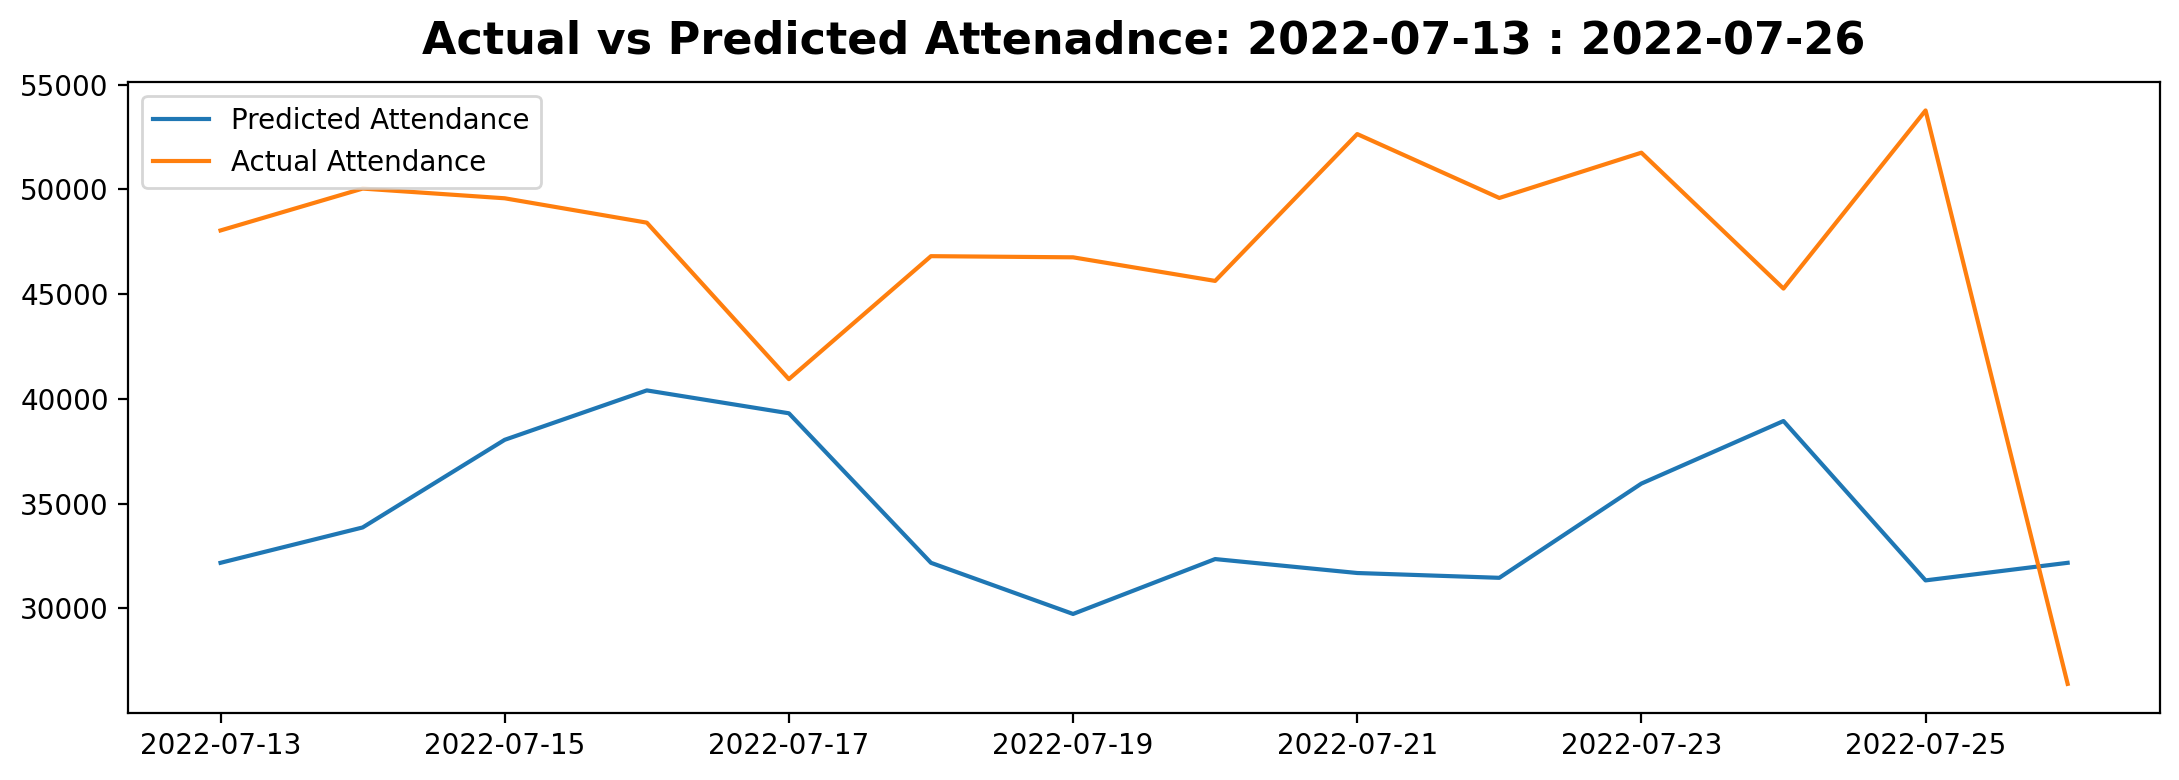

In [63]:
plt.plot(last_two_weeks_df['predicted_attendance'], label='Predicted Attendance')
plt.plot(last_two_weeks_df['attendance'], label='Actual Attendance')

# Add legend
plt.legend()

plt.title("Actual vs Predicted Attenadnce: 2022-07-13 : 2022-07-26")

# Show the plot
plt.show()


### Prediction for Next Week

In [23]:
def generate_prediction_df(df):

    """
    Generates a DataFrame for making attendance predictions based on provided features.

    Parameters:
    - df (pd.DataFrame): The original DataFrame containing historical attendance data with features.

    Returns:
    pd.DataFrame: DataFrame prepared for making attendance predictions with columns such as 'USAGE_DATE',
                  'holiday', 'season', 'month', 'year', 'is_weekend', 'lag_7', and 'lag_8'.
    """
    
    es_holidays = holidays.Spain()

    prediction_df = pd.DataFrame({
        'USAGE_DATE': ['2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02']
    })

    prediction_df['USAGE_DATE'] = pd.to_datetime(prediction_df['USAGE_DATE'])
    prediction_df['holiday'] = prediction_df['USAGE_DATE'].dt.date.astype(str).isin(es_holidays).astype(int)
    prediction_df['season'] = 0
    prediction_df['month'] = prediction_df['USAGE_DATE'].dt.month
    prediction_df['year'] = prediction_df['USAGE_DATE'].dt.year
    prediction_df['is_weekend'] = (prediction_df['USAGE_DATE'].dt.dayofweek >= 5).astype(int)
    prediction_df['lag_7'] = list(df['attendance'][len(df) - 7:])
    prediction_df['lag_8'] = list(df['attendance'][len(df) - 8:-1])

    return prediction_df

In [24]:
prediction_df = generate_prediction_df(df_attendance)

In [25]:
# Generate DMatrix for XGBoost

prediction_for_matrix = prediction_df.drop(columns=['USAGE_DATE'])
pred_dmatrix = xgb.DMatrix(prediction_for_matrix)
predictions =  bst.predict(pred_dmatrix)

In [26]:
# Add predictions to dataset

prediction_df['predicted_attendance'] = predictions
prediction_df = prediction_df.set_index('USAGE_DATE')
prediction_df

,holiday,season,month,year,is_weekend,lag_7,lag_8,predicted_attendance
USAGE_DATE,,,,,,,,
2022-07-27,0,0,7,2022,0,45627,46753,35072.937500
2022-07-28,0,0,7,2022,0,52637,45627,30098.685547
2022-07-29,0,0,7,2022,0,49586,52637,33395.871094
2022-07-30,0,0,7,2022,1,51748,49586,32714.017578
2022-07-31,0,0,7,2022,1,45261,51748,38466.019531
2022-08-01,0,0,8,2022,0,53764,45261,30554.984375
2022-08-02,0,0,8,2022,0,26391,53764,33670.863281


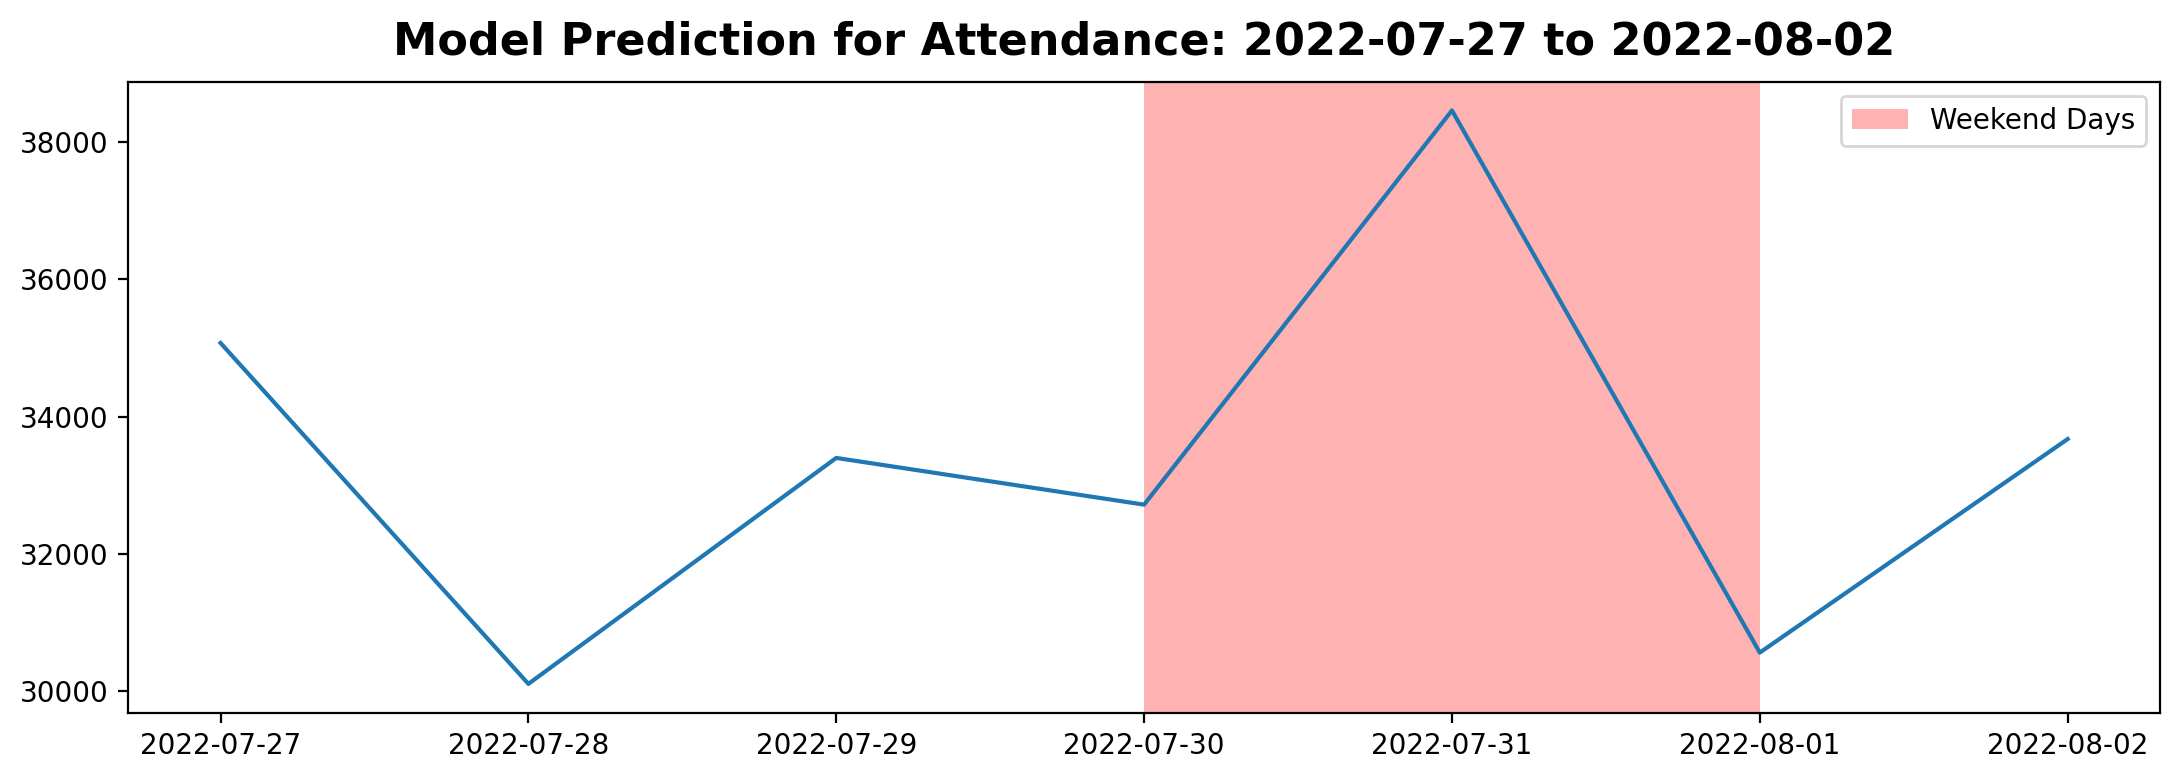

In [27]:
# Plot the predicted attendance 

start_date = prediction_df.index[3]
end_date = prediction_df.index[5]

plt.axvspan(start_date, end_date, facecolor='red', alpha=0.3,  label='Weekend Days')
plt.legend()
plt.title("Model Prediction for Attendance: 2022-07-27 to 2022-08-02")
plt.plot(prediction_df['predicted_attendance'])


### Timeslot features

For each time slot, we calculate with regards to attraction and park the:
- Time since opening
- Time until closing

4 Features in total

In [ ]:
def create_timeslot_features(df):
    # Calculate tso_attraction: how long the attraction has been open
    df['tso_attraction'] = (df['DEB_TIME'] - df['DEB_TIME_ATTR']).dt.total_seconds() / 60

    # Calculate tuc_attraction: how much time is left until the attraction closes
    df['tuc_attraction'] = (df['FIN_TIME_ATTR'] - df['DEB_TIME']).dt.total_seconds() / 60

    # Calculate tso_park: how long the park has been open
    df['tso_park'] = (df['DEB_TIME'] - df['DEB_TIME_PARK']).dt.total_seconds() / 60

    # Calculate tuc_park: how much time is left until the park closes
    df['tuc_park'] = (df['FIN_TIME_PARK'] - df['DEB_TIME']).dt.total_seconds() / 60

    return df

In [ ]:
df_timeslot = create_timeslot_features(df_merged)
df_timeslot.head()

### Individual attraction features

We want to find the best way to estimate in the future what is the "normal state" of a given attraction.

In [ ]:
# Extract day of the week and time of the day
data['day_of_week'] = data['date'].dt.day_name()
data['hour_of_day'] = data['date'].dt.hour

# Group by day of the week and calculate the mean for each hour
mean_by_day_hour = data.groupby(['day_of_week', 'hour_of_day'])['MW'].mean().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(mean_by_day_hour, cmap='BuPu', aspect='auto')
plt.colorbar(label='Mean MW')
plt.title('Correlation between Day of the Week and Time of the Day with MW')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(range(24), labels=range(24))
plt.yticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

In [ ]:
def create_attraction_features(df):
    return

### Relationship between attractions features

We aim at capturing the patterns between attractions.

In [ ]:
pd.set_option('display.max_columns', None)
df_merged.head()

### Interactions with other park events

These features aim at translating potential behaviours of clients related to activites that are not attractions within the park (e.g. parades).
- Time since last parade
- Time until next parade

2 features

In [ ]:
def create_interaction_features(df):
    # Find the time since the last parade (ts_last_parade)
    parade_times = ['PARADE_1', 'PARADE_2', 'NIGHT_SHOW']

    for parade_time in parade_times:
        df[f'ts_last_{parade_time}'] = (df['DEB_TIME'] - df[parade_time]).dt.total_seconds() / 60  # in minutes

    # Find the minimum positive time since the last parade
    positive_times_last = df.filter(like='ts_last', axis=1)
    df['ts_last_parade'] = positive_times_last[positive_times_last > 0].min(axis=1)

    # Drop intermediate columns
    df.drop(columns=[f'ts_last_{parade_time}' for parade_time in parade_times], inplace=True)

    # Find the time until the next parade (tu_next_parade)
    for parade_time in parade_times:
        df[f'tu_next_{parade_time}'] = (df[parade_time] - df['DEB_TIME']).dt.total_seconds() / 60  # in minutes

    # Find the minimum positive time until the next parade
    positive_times_next = df.filter(like='tu_next', axis=1)
    df['tu_next_parade'] = positive_times_next[positive_times_next > 0].min(axis=1)

    # Drop intermediate columns
    df.drop(columns=[f'tu_next_{parade_time}' for parade_time in parade_times], inplace=True)

    return df

### Weather features

Weather conditions highly influence the way clients behave inside the theme park. If the weather is bad, they will more likely resort to indoors activities (shops, restaurants) and more protected attractions.
<br>
With these features, we want to capture broad weather trends (temperature from the past years at the same period, main weather probabilities) and update them with the latest weather observed (i.e. a week before forecasting).

Features based on weather in the past years within a 2 week interval surrounding the date.
- proba_cloud_past
- proba_rain_past
- proba_clear_past
- proba_snow_past
- temp_mean_past
- temp_1quartile_past
- temp_3quartile_past

Features based on recent weather (calculated on the latest week of data available)
- proba_cloud_present
- proba_rain_present
- proba_clear_present
- proba_snow_present
- temp_mean_present
- temp_1quartile_present
- temp_3quartile_present


In [ ]:
df_weather = pd.read_csv(WEATHER_PATH)
df_weather.head()

In [ ]:
df_weather['dt'] = pd.to_datetime(df_weather['dt_iso'].str[:19])

In [ ]:
df_weather.weather_main.unique()

In [ ]:
import pandas as pd
import numpy as np

def calculate_weather_stats(df_weather):
    # Sort the dataframe by the 'dt' column
    df_weather = df_weather.sort_values(by='dt')

    # Define a function to calculate quartiles
    def calculate_quartiles(series):
        return np.percentile(series, [25, 75])

    # Define a function to calculate probabilities
    def calculate_probabilities(series, value):
        return (series == value).mean()

    # Calculate the statistics for each day
    result = []
    for i in range(len(df_weather)):
        current_date = df_weather.iloc[i]['dt']
        start_date = current_date - pd.DateOffset(weeks=53)
        end_date = current_date - pd.DateOffset(weeks=51)

        # Filter the dataframe for the specified date range
        selected_data = df_weather[(df_weather['dt'] >= start_date) & (df_weather['dt'] <= end_date)]

        # Skip if selected_data is empty
        if selected_data.empty:
            continue

        # Calculate probabilities
        proba_cloud_past = calculate_probabilities(selected_data['weather_main'], 'Clouds')
        proba_rain_past = calculate_probabilities(selected_data['weather_main'], 'Rain')
        proba_clear_past = calculate_probabilities(selected_data['weather_main'], 'Clear')
        proba_snow_past = calculate_probabilities(selected_data['weather_main'], 'Snow')

        # Calculate temperature statistics
        temp_mean_past = selected_data['temp'].mean()
        temp_quartiles_past = calculate_quartiles(selected_data['temp'])
        temp_1quartile_past, temp_3quartile_past = temp_quartiles_past

        # Append the results for the current date
        result.append({
            'dt': current_date,
            'proba_cloud_past': proba_cloud_past,
            'proba_rain_past': proba_rain_past,
            'proba_clear_past': proba_clear_past,
            'proba_snow_past': proba_snow_past,
            'temp_mean_past': temp_mean_past,
            'temp_1quartile_past': temp_1quartile_past,
            'temp_3quartile_past': temp_3quartile_past
        })

    # Create a new dataframe from the results
    result_df = pd.DataFrame(result)

    return result_df


In [ ]:
# Assuming df_weather is your original dataframe
result_df = calculate_weather_stats(df_weather)
result_df

## Choosing candidate models

In [ ]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## Evaluate the performance and fine-tune

## Explainability

In [ ]:
df_merged.columns

In [ ]:

latest_timestamp = df_merged['DEB_TIME'].max()
one_year_ago = latest_timestamp - pd.DateOffset(years=1)

# Group by date and take the first line to get unique attendance values for each date
df_last_year = df_merged[df_merged['DEB_TIME'] >= one_year_ago]

In [ ]:
# Question 1: Number of visitors on the last year of data
# Group by date and take the first line to get unique attendance values for each date
attendance_last_year = df_last_year.groupby('WORK_DATE')['ATTENDANCE_PARK'].first()
total_visitors_last_year = attendance_last_year.sum()

print("Number of visitors on the last year of data:", total_visitors_last_year)


In [ ]:
# Question 2: Sum of guest_carried across all attractions per visitor daily
daily_guest_carried_sum = df_last_year.groupby(['WORK_DATE'])['GUEST_CARRIED'].sum().mean()
print("Average number of rides daily:", daily_guest_carried_sum)

print(f'Average number of rides per guest daily: {daily_guest_carried_sum*365/total_visitors_last_year}')

In [ ]:
# Question 3: Average waiting time per attraction
average_waiting_time_per_attraction = df_last_year.groupby('ATTRACTION')['WAIT_TIME_MAX'].mean()
print(f"Average waiting time per attraction:{average_waiting_time_per_attraction}")

average_waiting_time = df_last_year['WAIT_TIME_MAX'].mean()
print(f"Average waiting time:{average_waiting_time}")